In [1]:
import os
import glob
import cv2 
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def readImage(location):
    image = nib.load(location)
    return np.array(image.get_fdata())[:,:,:,0]/np.array(image.get_fdata())[:,:,:,0].max()

In [3]:
def getSegments(subject):
    ret,thresh_low = cv2.threshold(subject,0.20,255,cv2.THRESH_BINARY)
    ret,thresh_med = cv2.threshold(subject,0.40,255,cv2.THRESH_BINARY)
    ret,thresh_high = cv2.threshold(subject,0.60,255,cv2.THRESH_BINARY)
    
    return np.array([
    cv2.bitwise_and(thresh_low[:,:,:],subject[:,:,:]),
    cv2.bitwise_and(thresh_med[:,:,:],subject[:,:,:]),
    cv2.bitwise_and(thresh_high[:,:,:],subject[:,:,:])])

In [4]:
#Alzhimers Dataset
ad = []
for x in tqdm(glob.glob('./Dataset/AD/*/*/*.nii')):
    ad.append(getSegments(readImage(x)))
    
ad = np.array(ad)

#Normal Dataset
cn = []
for x in tqdm(glob.glob('./Dataset/CN/*/*/*.nii')):
    cn.append(getSegments(readImage(x)))
    
cn = np.array(cn)


#MIC Dataset
mic = []
for x in tqdm(glob.glob('./Dataset/MIC/*/*/*.nii')):
    mic.append(getSegments(readImage(x)))
    
mic = np.array(mic)

X = np.append(ad,cn,axis=0)
X = np.append(X,mic,axis=0)
Y = np.array([0]*ad.shape[0] + [1]*cn.shape[0] + [2]*mic.shape[0])

100%|████████████████████████████████████████████████████████████████████████████████| 432/432 [00:52<00:00,  8.16it/s]


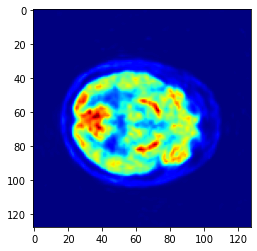

In [5]:
plt.imshow(readImage(glob.glob('./Dataset/AD/*/*/*.nii')[155])[:,:,30],cmap='jet')
plt.show()

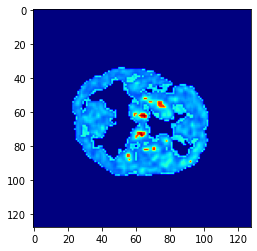

In [6]:
plt.imshow(X[100,0,:,:,32],cmap='jet')
plt.show()

In [7]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

In [8]:
Y= ohe.fit_transform(Y.reshape(-1,1)).asarray()

In [9]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.25)

In [12]:
y_train = y_train.toarray()
y_test = y_test.toarray()

## Making the Model

In [57]:
import keras
from keras.models import Model
from keras.layers import Conv2D,Dense,MaxPool2D,ReLU,Input,concatenate,Flatten,BatchNormalization, Dropout

In [58]:
X[:,0,:,:].shape

(1002, 128, 128, 63)

In [72]:
#For low intensity segments
input_li = Input(shape=(128,128,63),name='input_li')
model_li = Conv2D(filters=256, kernel_size=2, strides=2,padding='same', activation='relu')(input_li)
model_li = BatchNormalization(center=True, scale=True)(model_li)
model_li  = Dropout(0.5)(model_li)
model_li = Conv2D(filters=128, kernel_size=2, strides=2,padding='same', activation='relu')(model_li)
model_li = BatchNormalization(center=True, scale=True)(model_li)
model_li  = Dropout(0.5)(model_li)

#For mid intensity segments
input_mi = Input(shape=(128,128,63),name='input_mi')
model_mi = Conv2D(filters=256, kernel_size=2, strides=2,padding='same', activation='relu')(input_mi)
model_mi = BatchNormalization(center=True, scale=True)(model_mi)
model_mi  = Dropout(0.5)(model_mi)
model_mi = Conv2D(filters=128, kernel_size=2, strides=2,padding='same', activation='relu')(model_mi)
model_mi = BatchNormalization(center=True, scale=True)(model_mi)
model_mi  = Dropout(0.5)(model_mi)

#For mid intensity segments
input_hi = Input(shape=(128,128,63),name='input_hi')
model_hi = Conv2D(filters=256, kernel_size=2, strides=2,padding='same', activation='relu')(input_hi)
model_hi = BatchNormalization(center=True, scale=True)(model_hi)
model_hi  = Dropout(0.5)(model_hi)
model_hi = Conv2D(filters=128, kernel_size=2, strides=2,padding='same', activation='relu')(model_hi)
model_hi = BatchNormalization(center=True, scale=True)(model_hi)
model_hi  = Dropout(0.5)(model_hi)

#Concatenated
concat = concatenate([model_li,model_mi,model_hi],axis=-1)

#Classification Network
classifier = Conv2D(filters=128, kernel_size=2, strides=2,padding='same', activation='relu')(concat)
classifier = BatchNormalization(center=True, scale=True)(classifier)
classifier = Dropout(0.5)(classifier)
classifier = Conv2D(filters=64, kernel_size=2, strides=2,padding='same', activation='relu')(classifier)

flatten = Flatten()(classifier)

dense = Dense(128, activation='relu')(flatten)
output = Dense(3, activation='softmax')(dense)

In [73]:
model = Model([input_li,input_mi,input_hi],output)

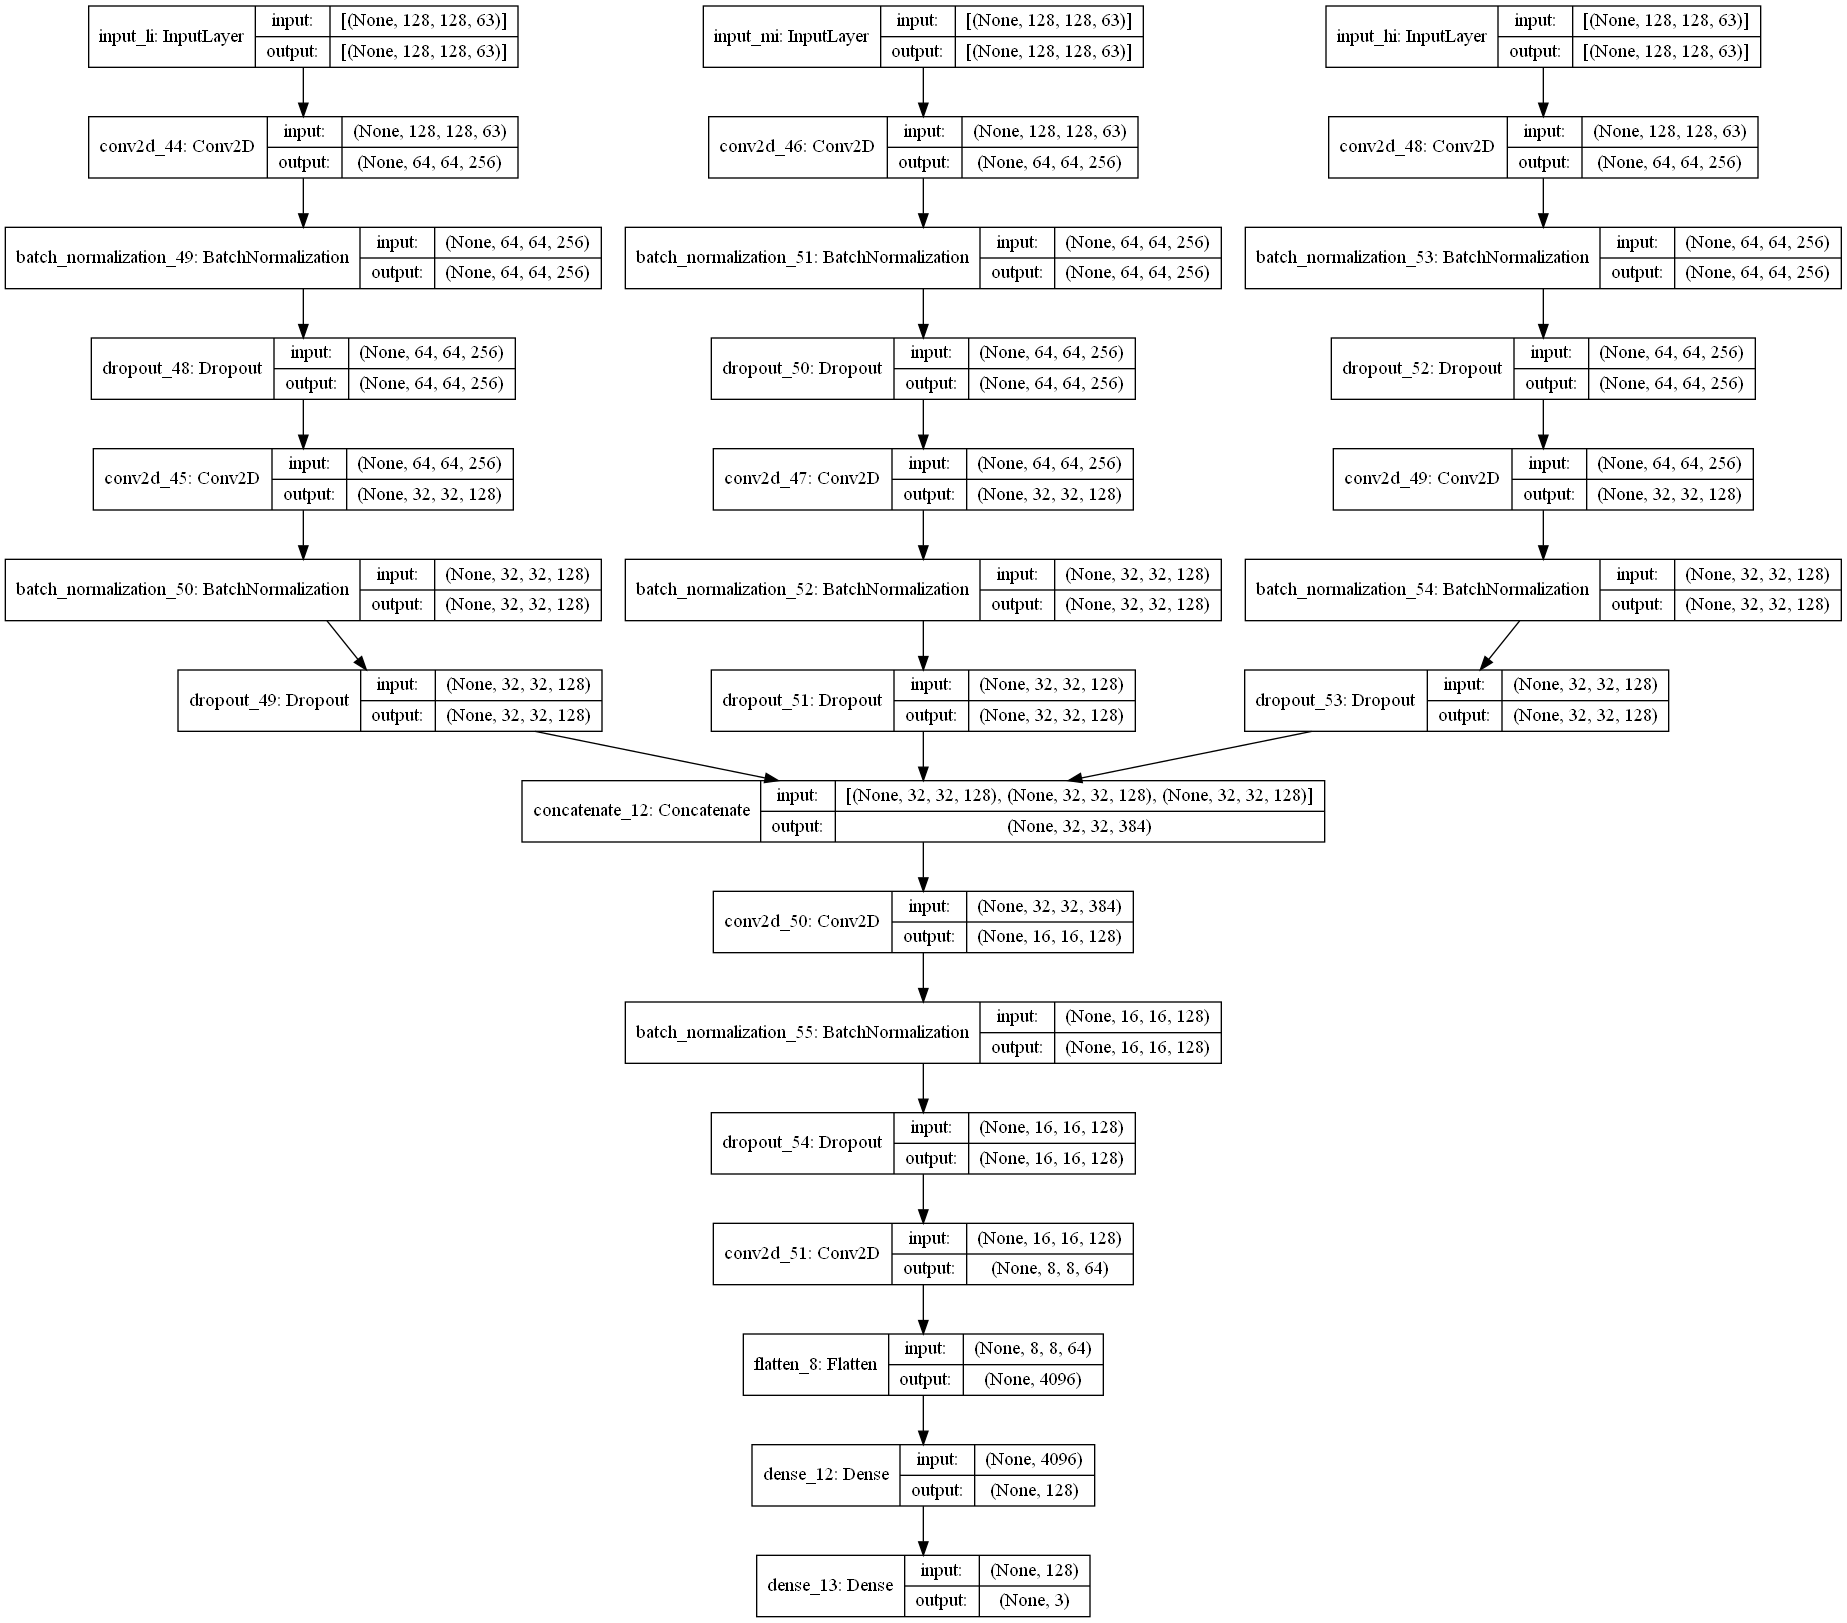

In [74]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True,show_layer_names=True,rankdir='TB',expand_nested=True)

In [75]:
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

In [80]:
X_li_train = X_train[:,0,:,:]
X_mi_train = X_train[:,1,:,:]
X_hi_train = X_train[:,2,:,:]

In [81]:
X_li_test = X_test[:,0,:,:]
X_mi_test = X_test[:,1,:,:]
X_hi_test = X_test[:,2,:,:]

In [84]:
model.fit(x=[X_li_train,X_mi_train,X_hi_train],
          y=y_train,
          batch_size=10,
          epochs=100,
          validation_data=([X_li_test,X_mi_test,X_hi_test], y_test))

MemoryError: Unable to allocate 2.89 GiB for an array with shape (751, 128, 128, 63) and data type float32